# League of Legends Project

## Part 1: Data Collection
    Ranked match data will be collected from each Summoner Name provided. 

    Part 1A: Data Collection from Data Dragon
        - create mapping dictionaries from the json files provided

    Part 1B: Data Collection from Riot API
        - extract data from RIOT API
    
## Part 2: Data Analysis & Machine Learning
    Exploratory Data Analysis will be done on the match data to discover basic statistics and trends.
    
    Part 2A: Data Wrangling and Cleaning
        - wrangle and manipulate data table for consistency
        - prepare data for visualization and machine learning

    Part 2B: Data Visualization
        - visualize trends and correlations show in the data
        - create dashboard to visualize game statistics by player
        
    Part 2C: Machine Learning
        - using data extracted from top 100 players, predict the outcome of a match based off the different variables provided
        - using data extracted from top 100 players, identify and group champions based off classification algorithm

# Part 1A

In [1]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
import numpy as np
import requests
import regex as re
import json
import pprint
import time
from bs4 import BeautifulSoup

## Champion JSON

In [ ]:
def create_champion_mapping_dict(file_name):
    champion_key_dict = {}
    with open(f'json_files/{file_name}', encoding = 'utf-8') as f:
        champion_json = json.load(f)
        for champion, info in champion_json['data'].items():
            champion_name = champion
            for c_key, c_value in info.items():
                if c_key == 'key':
                    champion_key_dict[champion_name] = int(c_value)
    return champion_key_dict

champion_key_dict = create_champion_mapping_dict('champion.json')

## Item JSON

In [ ]:
def create_item_mapping_dict(file_name):
    item_key_dict = {}
    with open(f'json_files/{file_name}', encoding = 'utf-8') as f:
        item_data = json.load(f)
        for item, info in item_data['data'].items():
            item_id = item
            for i_key, i_value in info.items():
                if i_key == 'name':
                    item_key_dict[int(item_id)] = i_value
    return item_key_dict

item_key_dict = create_item_mapping_dict('item.json')

## Queue JSON

In [ ]:
def create_queue_mapping_dict(file_name):
    queue_info_dict = {}
    with open(f'json_files/{file_name}', encoding = 'utf-8') as f:
        queue_data = json.load(f)
        for queue in queue_data:
            queue_key = queue['queueId']
            queue_name = queue['description']
            queue_notes = str(queue['notes'])
            if 'deprecated' not in queue_notes.lower():
                queue_info_dict[queue_key] = str(queue_name).upper()

    queue_info_dict_reverse = {str(v).upper(): k for (k,v) in queue_info_dict.items()}
    return queue_info_dict, queue_info_dict_reverse

queue_key_dict, queue_key_dict_reverse = create_queue_mapping_dict('queue.json')

## Summoner Spell JSON

In [ ]:
def create_summoner_spell_mapping_dict(file_name):
    ss_info_dict = {}
    with open(f'json_files/{file_name}', encoding = 'utf-8') as f:
        ss_data = json.load(f)
        for s_spell, info in ss_data['data'].items():
            for key in info:
                ss_key = info['key']
                ss_name = info['name']
                ss_description = info['description']
                ss_info_dict[ss_name] = (ss_key, ss_description)
    return ss_info_dict

ss_key_dict = create_summoner_spell_mapping_dict('summoner.json')

## Season JSON

In [ ]:
def create_season_mapping_dict(file_name):
    season_info_dict = {}
    with open(f"json_files/{file_name}", encoding = "utf-8") as f:
        season_data = json.load(f)
        for season in season_data:
            season_info_dict[season['id']] = season['season']
    return season_info_dict
    
season_key_dict = create_season_mapping_dict('season.json')

# Part 1B

In [ ]:
REQUEST_HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.66 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9',
    'Accept-Charset': 'application/x-www-form-urlencoded; charset=UTF-8',
    'Origin': 'https://developer.riotgames.com',
    'X-Riot-Token': ''
    }
RIOT_API = ''

## Getting Account Information Using Summoner Name

In [ ]:
def get_puu_id(summoner_name, riot_api_key = RIOT_API, request_headers = REQUEST_HEADERS, access = True):
    summoner_name_updated = summoner_name.replace(' ', '%20')
    url = 'https://na1.api.riotgames.com/lol/summoner/v4/summoners/by-name/'
    account_url = url + summoner_name_updated
    riot_headers = request_headers
    riot_headers["X-Riot-Token"] = riot_api_key
    while access:
        req = requests.get(account_url, headers = riot_headers)
        if req.status_code == 200:
            account_info = json.loads(req.content.decode("utf-8"))
            puu_id = account_info['puuid']
            access = False

        elif req.status_code == 404:
            puu_id = None
            access = False

        else:
            time.sleep(10)
    return  puu_id

## Getting A List of Match IDs Using PUU ID

In [ ]:
def get_match_ids(puu_id, start, end, riot_api_key = RIOT_API, request_headers = REQUEST_HEADERS, access = True):
    match_ids = []
    match_history_url = f'https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/{puu_id}/ids?start={start}&count={end}'
    riot_headers = request_headers
    riot_headers["X-Riot-Token"] = riot_api_key

    while access:
        req = requests.get(match_history_url, headers = riot_headers)
        if req.status_code == 200:
            match_id_info = json.loads(req.content.decode("utf-8"))
            for match_id in match_id_info:
                match_ids.append(match_id)
            access = False
        else:
            print('Waiting for 10 seconds to refresh restriction request...')
            time.sleep(10)

    return match_ids

## Get Match Information Using Match ID

In [ ]:
def get_match_details(match_id, riot_api_key = RIOT_API, request_headers = REQUEST_HEADERS, access = True):
    match_url = 'https://americas.api.riotgames.com/lol/match/v5/matches/' + str(match_id)
    riot_headers = request_headers
    riot_headers["X-Riot-Token"] = riot_api_key

    while access:
        req = requests.get(match_url, headers = riot_headers)
        if req.status_code == 200:
            match_details = json.loads(req.content.decode("utf-8"))
            access = False

        elif req.status_code == 404:
            print(f'{match_id} - DATA NOT FOUND - MATCH FILE NOT FOUND')
            match_details = None
            access = False
            
        else:
            print(req.status_code)
            print('Waiting for 10 seconds to refresh restriction request...')
            time.sleep(10)

    return match_details

## Cleaning and Reducing Match Data

In [ ]:
def clean_and_reduce_match_data(match_details, queue_type, queue_mapping_info = queue_key_dict_reverse):
    queue_filter = queue_mapping_info[queue_type.upper()]
    match_cleaned_dict = {}
    for key, value in match_details['info'].items():

        if key == 'gameId':
            match_id = value

        if key == 'gameMode':
            match_type = value
            
        if key == 'participants':
            participant_details = value
        
        if key == 'queueId':
            if value == queue_filter:
                queue_id = value
                match_cleaned_dict[(match_type, queue_id, match_id)] = participant_details
            else:
                return None
    return match_cleaned_dict

In [ ]:
def filter_match_data_by_puuid(match_cleaned_dict, puu_id):
    for match_id, match_details in match_cleaned_dict.items():
        for participant_dict in match_details:
            if participant_dict['puuid'] == puu_id:
                return {match_id[0] + '_' + str(match_id[1]) + '_' + str(match_id[2]): participant_dict}

In [ ]:
def remove_perks_attribute(match):
    for key, info in match.items():
        for key in list(info.keys()):
            if key == 'perks':
                del info[key]

    return match

## Turn Match Data into DataFrame

In [ ]:
def make_match_df(match):
    match_df = pd.DataFrame.from_dict(match, orient = 'index')
    return match_df

## Create Super Function for Data Collection

In [ ]:
def get_match_history_by_summoner_name(summoner_name, start, end, queue_type, riot_api = RIOT_API, request_headers = REQUEST_HEADERS):
    puu_id = get_puu_id(summoner_name, riot_api, request_headers)

    if puu_id != None:
        match_ids = get_match_ids(puu_id, start, end, riot_api, request_headers)

        matches_df_listed = []

        for match_id in match_ids:
            match_detail = get_match_details(match_id, riot_api, request_headers)
            if match_detail != None:
                match_cleaned = clean_and_reduce_match_data(match_detail, queue_type)
                if match_cleaned != None:
                    match_cleaned_filtered = filter_match_data_by_puuid(match_cleaned, puu_id)

                    match_final = remove_perks_attribute(match_cleaned_filtered)

                    match_df = make_match_df(match_final)
    
                    matches_df_listed.append(match_df)
                    
                else:
                    print(f'Match ID: {match_id} IS NOT OF THE QUEUE TYPE: {queue_type.upper()}')
                    continue

        if matches_df_listed != []:
            return pd.concat(matches_df_listed)
                
        
    else:
        return f'NO PUU_ID FOUND FOR SUMMONER: {summoner_name}'

# Part 2A

## Create Super Function for Initial Data Cleanup


In [ ]:
def clean_columns(data):
    data = data.reset_index()

    cleaned_cols = list(data.columns.values)[1:]

    data[['matchType', 'queueId', 'matchId']] = data['index'].str.split('_', expand = True)

    cleaned_cols = ['queueId', 'matchId'] + cleaned_cols
    data = data[cleaned_cols]
    
    data['queueId'] = data['queueId'].astype(int)

    return data

def mapping_data_values(data, mapping_key):
    if mapping_key == 'Q':
        data['queueId'] = data['queueId'].map(queue_key_dict)

    if mapping_key == 'I':
        item_columns = ["item0", "item1", "item2", "item3", "item4", "item5", "item6"]
        for col in item_columns:
            data[col] = data[col].map(item_key_dict)

    if mapping_key == 'S':
        summoner_columns = ['summoner1Id', 'summoner2Id']
        for col in summoner_columns:
            data[col] = data[col].map(ss_key_dict)
    
    if mapping_key == 'T':
        team_color = data['teamId'].map({100: 'Blue', 200: 'Red'})
        data.insert(1, 'teamColor', team_color)
    
    return data

In [ ]:
def initial_cleanup(data):
    data = clean_columns(data)

    data = mapping_data_values(data, 'Q')

    data = mapping_data_values(data, 'I')

    data = mapping_data_values(data, 'S')

    data = mapping_data_values(data, 'T')

    return data

## Combine All Super Functions

In [ ]:
def get_clean_match_data_by_summoner(summoner_name, start, end, queue_type):

    df = get_match_history_by_summoner_name(summoner_name, start, end, queue_type)
    if isinstance(df, pd.DataFrame):
        df = initial_cleanup(df)
    else:
        df = f'NO MATCHES OF THE TYPE {queue_type.upper()} IN THE LAST {end} GAMES'   

    return df

In [ ]:
def get_summoner_match_clean_df(summoner_name, num_games, q_type):

    solo_game_count = 0
    starting = 101
    df_listed = []
    ending = 1

    print(f'STARTED PROCESSING FOR SUMMONER: {summoner_name}')
    print(f'ROW {starting} HAS BEEN PROCESSED')

    while solo_game_count < num_games:
        df = get_clean_match_data_by_summoner(summoner_name = summoner_name, start = starting, end = ending, queue_type = q_type)
        starting += ending
        print(f'ROW {starting} HAS BEEN PROCESSED')

        if isinstance(df, pd.DataFrame):
            solo_game_count += df.shape[0]
            print(f'SOLO GAME ROW COUNT: {solo_game_count}')
            df_listed.append(df)

    final = pd.concat(df_listed)
    return final

## Getting Most Recent 50 Solo Ranked Matches From Top 100 Challenger Level Players

In [ ]:
def get_top_100_challenger_players(chall_url):
    response = requests.get(chall_url)
    html_soup  = BeautifulSoup(response.text, 'html.parser')
    challlenger_top_100_snames = []

    chall_top_4 = html_soup.find_all('li', class_ = 'ranking-highest__item')
    for challenger in chall_top_4:
        chall_sname = challenger.find('a', class_ = 'ranking-highest__name').text
        challlenger_top_100_snames.append(chall_sname)
    
    chall_rest = html_soup.find_all('tr', class_ = 'ranking-table__row')
    for challenger in chall_rest:
        challlenger_top_100_snames.append(challenger.span.text)

    return challlenger_top_100_snames

In [ ]:
challenger_top100_snames = get_top_100_challenger_players('https://na.op.gg/ranking/ladder/page=1')

In [ ]:
match_df_listed = []
for challenger in challenger_top100_snames:
    match_df = get_summoner_match_clean_df(summoner_name = challenger, num_games = 50, q_type = '5v5 Ranked Solo Games')
    match_df_listed.append(match_df)

In [ ]:
final_df = pd.concat(match_df_listed)
final_df.head()

In [ ]:
final_df.shape

In [ ]:
final_df.to_csv('export_data/data_6_18.csv', index = False)

## Final Cleanup to Combined Data

In [43]:
match_data_total = pd.read_csv('export_data/data_combined.csv')
match_data_total.loc[match_data_total['teamPosition'] == 'UTILITY', 'teamPosition'] = 'SUPPORT'
match_data_total.loc[match_data_total['championName'] == 'MonkeyKing', 'championName'] = 'Wukong'

In [44]:
subset = ['puuid', 'kills', 'deaths','assists', 'totalDamageDealt', 'totalDamageTaken', 'totalHeal', 'item0', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6']
match_data_total_deduped = match_data_total.drop_duplicates(subset, keep = 'first')

In [45]:
match_data_total_deduped.shape

(12282, 100)

In [46]:
item_cols = ['item0', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6']

for col in item_cols:
    match_data_total_deduped[col] = match_data_total_deduped[col].fillna(value = 'None')

In [47]:
match_data_total_deduped['inhibitorsLost'] = match_data_total_deduped['inhibitorsLost'].fillna(value = 0)
match_data_total_deduped['nexusLost'] = match_data_total_deduped['nexusLost'].fillna(value = 0)
match_data_total_deduped['turretsLost'] = match_data_total_deduped['turretsLost'].fillna(value = 0)
match_data_total_deduped['damageDealtToBuildings'] = match_data_total_deduped['damageDealtToBuildings'].fillna(value = 0)

In [48]:
match_data_total_deduped.to_csv('export_data/data_combined_cleaned.csv', index = False)

# Part 2B

## Questions to Visualize:

### Who is the most played champion by lane?
    - select the top 3 played champions by lane and display the # of games played
    
### Who are the top 3 champions that hold the highest win rate by lane?
    - visualize win rates by lane and visualize win rate by champions
    - to decrease bias from lack of games played, the champions that have at least average game count will only be used when looking at win rate

### What is the k/D/A for the top 10 played champions?
    - after filtering the data for top 10 played champions, visualize the average K/D/A

### How correlated is offensive/defensive statistics to winning?
    - create correlation matrix to determine variables highly correlated with win/loss
    - filter correlation plot for any variables that have a correlation higher than .25 or lower than -.25

In [2]:
match_data_total_deduped = pd.read_csv('export_data/data_combined_cleaned.csv')

In [3]:
test = match_data_total_deduped.groupby(['teamPosition', 'championName'])['matchId'].agg('count').reset_index()
test.rename(columns = {'matchId':'matchCount'}, inplace = True)
test_sorted = test.sort_values(['teamPosition', 'matchCount'], ascending = [True, False])
test_filtered = test_sorted.loc[test_sorted['teamPosition'] != 'AFK']
test_filtered
top3_bottom = ['Ezreal', 'Kaisa', 'Tristana']
top3_jungle = ['Kindred', 'Kayn', 'Rumble']
top3_mid = ['Sylas', 'LeeSin', 'Lucian']
top3_top = ['LeeSin', 'Jayce', 'Gwen']
top3_supp = ['Thresh', 'Nautilus', 'Karma']

bot_mask = test_sorted['teamPosition'] == 'BOTTOM'
jung_mask = test_sorted['teamPosition'] == 'JUNGLE'
mid_mask = test_sorted['teamPosition'] == 'MIDDLE'
top_mask = test_sorted['teamPosition'] == 'TOP'
supp_mask = test_sorted['teamPosition'] == 'SUPPORT'

top3_all_lanes = test.loc[
    (bot_mask & test['championName'].isin(top3_bottom)) |
    (jung_mask & test['championName'].isin(top3_jungle)) |
    (mid_mask & test['championName'].isin(top3_mid)) |
    (top_mask & test['championName'].isin(top3_top)) |
    (supp_mask & test['championName'].isin(top3_supp))
]
top3_all_lanes_sorted = top3_all_lanes.sort_values(['teamPosition', 'matchCount'], ascending = [True, False])
top3_all_lanes_sorted

,teamPosition,championName,matchCount
12,BOTTOM,Ezreal,344
19,BOTTOM,Kaisa,296
42,BOTTOM,Tristana,249
76,JUNGLE,Kindred,248
91,JUNGLE,Rumble,179
74,JUNGLE,Kayn,157
178,MIDDLE,Sylas,244
150,MIDDLE,LeeSin,208
152,MIDDLE,Lucian,177
238,SUPPORT,Thresh,354


In [4]:
fig = px.bar(top3_all_lanes_sorted, x = 'teamPosition', y = 'matchCount', color = 'championName', text = 'matchCount',
             color_discrete_map = {
                'Ezreal': '#5F9EA0',
                'Tristana': '#FFA07A',
                'Kaisa': '#4B0082',
                'Rumble': '#CD853F',
                'Kindred': '#708090',
                'Kayn': '#4682B4',
                'Lucian': '#DCDCDC',
                'LeeSin': '#A0522D',
                'Sylas': '#191970',
                'Gwen': '#40E0D0',
                'Jayce': '#D2B48C',
                'Nautilus': '#2E8B57',
                'Thresh': '#556B2F',
                'Karma': '#FFB6C1'
            },

             labels = {'teamPosition': 'Position', 'matchCount': '# of Games Played', 'championName': 'Champion'}, title = 'Top 3 Champions Played by Position')
fig.update_layout(
    plot_bgcolor = 'rgb(0,0,0,0)',
    paper_bgcolor = 'rgb(0,0,0,0)',
    width = 800,
    height = 600,
    title_x = 0.5,
    legend = dict(bgcolor = 'white', yanchor = 'top', y = 0.96, xanchor = 'right', x = 1.15),
    legend_title = dict(font = dict(size = 12)),
)
fig.update_xaxes(categoryorder = 'total ascending')

fig.layout.legend.tracegroupgap = 8

fig.update_traces(texttemplate = '%{text} Games', textposition = 'inside', insidetextanchor = 'middle')
fig.show(renderer = 'notebook_connected')

In [5]:
match_data_total_deduped.head()

,queueId,teamColor,matchId,assists,baronKills,bountyLevel,champExperience,champLevel,championId,championName,championTransform,consumablesPurchased,damageDealtToBuildings,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,deaths,detectorWardsPlaced,doubleKills,dragonKills,firstBloodAssist,firstBloodKill,firstTowerAssist,firstTowerKill,gameEndedInEarlySurrender,gameEndedInSurrender,goldEarned,goldSpent,individualPosition,inhibitorKills,inhibitorsLost,item0,item1,item2,item3,item4,item5,item6,itemsPurchased,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicDamageTaken,neutralMinionsKilled,nexusKills,nexusLost,objectivesStolen,objectivesStolenAssists,participantId,pentaKills,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,profileIcon,puuid,quadraKills,role,sightWardsBoughtInGame,spell1Casts,spell2Casts,spell3Casts,spell4Casts,summoner1Casts,summoner2Casts,summonerId,summonerLevel,summonerName,teamEarlySurrendered,teamId,teamPosition,timeCCingOthers,timePlayed,totalDamageDealt,totalDamageDealtToChampions,totalDamageShieldedOnTeammates,totalDamageTaken,totalHeal,totalHealsOnTeammates,totalMinionsKilled,totalTimeCCDealt,totalTimeSpentDead,totalUnitsHealed,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,turretsLost,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win
0,5V5 RANKED SOLO GAMES,Blue,3944288481,13,0,0,8243,11,223,TahmKench,0,7,488.0,1419,488,17878,6,3,0,0,False,False,False,False,False,True,7039,6425,BOTTOM,0,0.0,Doran's Shield,Sunfire Aegis,Plated Steelcaps,Kindlegem,Ruby Crystal,None,Stealth Ward,18,0,1,BOTTOM,0,0,1,312,20774,4743,6487,0,0,0.0,0,0,5,0,10610,731,9696,4568,6zpHc103eNNhAt8xC6Ujhak476wF7TuTm4K4vrCU2Zuu9Y...,0,CARRY,0,71,4,11,2,3,4,-wR2sAu8IN0jiLgjgGyDQsjpnyX5tSwTwZHcIE7L9aS1TbyQ,274,From Iron,False,100,BOTTOM,14,1284,31384,5475,1105,16532,2087,0,98,105,140,1,0,0,0,349,0,0.0,0,16,3,4,9,True
1,5V5 RANKED SOLO GAMES,Blue,3944251280,11,0,0,6578,10,111,Nautilus,0,10,0.0,174,0,16060,5,7,0,0,False,False,False,False,False,False,6099,6000,UTILITY,0,1.0,Plated Steelcaps,Locket of the Iron Solari,Bulwark of the Mountain,Cloth Armor,Warden's Mail,Control Ward,Oracle Lens,28,1,2,BOTTOM,0,2,1,407,10589,4457,4313,0,0,1.0,0,0,5,0,5748,1951,6472,4568,6zpHc103eNNhAt8xC6Ujhak476wF7TuTm4K4vrCU2Zuu9Y...,0,SUPPORT,0,50,17,21,9,13,4,-wR2sAu8IN0jiLgjgGyDQsjpnyX5tSwTwZHcIE7L9aS1TbyQ,274,From Iron,False,100,SUPPORT,46,1347,21927,7026,671,11566,62,0,43,246,98,1,0,5589,616,779,0,9.0,0,53,8,6,31,False
2,5V5 RANKED SOLO GAMES,Red,3944226110,0,0,0,4583,8,202,Jhin,0,6,0.0,0,0,3309,5,2,0,0,False,False,False,False,False,True,4305,3100,BOTTOM,0,0.0,Serrated Dirk,Refillable Potion,Boots,Vampiric Scepter,None,Long Sword,Stealth Ward,16,0,1,NONE,358,0,1,281,148,0,1678,0,0,0.0,0,0,9,0,34032,3541,6081,4568,6zpHc103eNNhAt8xC6Ujhak476wF7TuTm4K4vrCU2Zuu9Y...,0,SUPPORT,0,36,17,3,10,2,3,-wR2sAu8IN0jiLgjgGyDQsjpnyX5tSwTwZHcIE7L9aS1TbyQ,274,From Iron,False,200,BOTTOM,3,912,34180,3541,0,8214,1718,216,99,7,75,3,0,0,0,454,0,3.0,0,18,2,3,10,False
3,5V5 RANKED SOLO GAMES,Red,3941904096,20,0,0,10417,13,111,Nautilus,0,11,320.0,999,320,30781,7,8,0,0,False,False,False,False,False,False,7821,6575,UTILITY,0,0.0,Plated Steelcaps,Locket of the Iron Solari,Bulwark of the Mountain,Control Ward,Kindlegem,Warden's Mail,Oracle Lens,27,0,0,BOTTOM,0,0,0,690,8449,5522,8327,0,0,0.0,0,0,10,0,7874,1919,10809,4568,6zpHc103eNNhAt8xC6Ujhak476wF7TuTm4K4vrCU2Zuu9Y...,0,SUPPORT,0,71,46,24,9,5,5,-wR2sAu8IN0jiLgjgGyDQsjpnyX5tSwTwZHcIE7L9aS1TbyQ,274,From Iron,False,200,SUPPORT,60,1841,21192,8025,1644,19624,1203,0,40,190,212,1,0,4868,584,487,0,1.0,0,64,9,8,35,True
4,5V5 RANKED SOLO GAMES,Red,3941845033,18,0,1,8840,12,111,Nautilus,0,10,796.0,796,796,15092,4,6,0,0,False,False,False,False,False,False,7579,6050,UTILITY,0,0.0,Ruby Crystal,Locket of the Iron Solari,Bulwark of the Mountain,Contro

In [6]:
win_ratio_df = match_data_total_deduped.groupby(['teamPosition', 'championName']).agg({'win': ['sum', 'count']}).droplevel(0, axis = 1)
win_ratio_df['winRatio'] = round(win_ratio_df['sum'] / win_ratio_df['count'], 4)
win_ratio_df = win_ratio_df.reset_index()
win_ratio_df = win_ratio_df.loc[win_ratio_df['teamPosition'] != 'AFK', ]
win_ratio_df.head()

,teamPosition,championName,sum,count,winRatio
4,BOTTOM,Aatrox,0,1,0.0000
5,BOTTOM,Aphelios,15,26,0.5769
6,BOTTOM,Ashe,24,47,0.5106
7,BOTTOM,Brand,2,2,1.0000
8,BOTTOM,Caitlyn,13,30,0.4333


In [7]:
win_ratio_df.groupby('teamPosition').mean()['count']
bottom_avg_game_count = win_ratio_df.groupby('teamPosition').mean()['count']['BOTTOM']
jung_avg_game_count = win_ratio_df.groupby('teamPosition').mean()['count']['JUNGLE']
mid_avg_game_count = win_ratio_df.groupby('teamPosition').mean()['count']['MIDDLE']
top_avg_game_count = win_ratio_df.groupby('teamPosition').mean()['count']['TOP']
supp_avg_game_count = win_ratio_df.groupby('teamPosition').mean()['count']['SUPPORT']

In [8]:
bottom_win_rates = win_ratio_df.loc[(win_ratio_df['teamPosition'] == 'BOTTOM') & (win_ratio_df['count'] >= bottom_avg_game_count), ].sort_values(by = 'winRatio', ascending = False).head(10)
jung_win_rates = win_ratio_df.loc[(win_ratio_df['teamPosition'] == 'JUNGLE') & (win_ratio_df['count'] >= jung_avg_game_count), ].sort_values(by = 'winRatio', ascending = False).head(10)
mid_win_rates = win_ratio_df.loc[(win_ratio_df['teamPosition'] == 'MIDDLE') & (win_ratio_df['count'] >= mid_avg_game_count), ].sort_values(by = 'winRatio', ascending = False).head(10)
top_win_rates = win_ratio_df.loc[(win_ratio_df['teamPosition'] == 'TOP') & (win_ratio_df['count'] >= top_avg_game_count), ].sort_values(by = 'winRatio', ascending = False).head(10)
supp_win_rates = win_ratio_df.loc[(win_ratio_df['teamPosition'] == 'SUPPORT') & (win_ratio_df['count'] >= supp_avg_game_count), ].sort_values(by = 'winRatio', ascending = False).head(10)

win_rates_top_10 = pd.concat([bottom_win_rates, jung_win_rates, mid_win_rates, top_win_rates, supp_win_rates])
win_rates_top_10['winRatio'] = round((win_rates_top_10['winRatio'] * 100), 1)


In [9]:
def graph_top10_win_rates(data, lane):
    data = data.loc[data['teamPosition'] == lane, ]
    fig = px.bar(data, x = 'championName', y = 'winRatio', text = 'winRatio', color = 'winRatio', color_continuous_scale = px.colors.sequential.Emrld,
                 labels = {'teamPosition': 'Position', 'winRatio': 'Win Percentage', 'championName': 'Champion'},
                 title = f'Top 10 Win Rates for {lane.title()} Position')
    fig.update_layout(
        plot_bgcolor = 'rgb(0,0,0,0)',
        paper_bgcolor = 'rgb(0,0,0,0)',
        width = 800,
        height = 600,
        title_x = 0.5,
        coloraxis_showscale = False,
        )
    fig.update_xaxes(categoryorder = 'total ascending')
    fig.update_yaxes(ticksuffix = '%', visible = False)
    fig.update_traces(texttemplate = '%{text}%', textposition = 'outside', insidetextanchor = 'end', 
                      textfont_color = '#000000', textfont_size = 14)

    return fig

In [10]:
team_positions = ['BOTTOM', 'SUPPORT', 'TOP', 'MIDDLE', 'JUNGLE']
top_10_by_position = []
for position in team_positions:
    fig = graph_top10_win_rates(win_rates_top_10, position)
    top_10_by_position.append(fig)

In [11]:
for fig in top_10_by_position:
    fig.show(renderer = 'notebook_connected')

In [12]:
win_correlations = match_data_total_deduped.corr()['win'].sort_values(ascending = False)
win_correlations

win                       1.000000
bountyLevel               0.461929
assists                   0.373235
turretKills               0.362904
largestKillingSpree       0.356634
                            ...   
inhibitorsLost           -0.571607
nexusLost                -0.607605
turretsLost              -0.714582
sightWardsBoughtInGame         NaN
unrealKills                    NaN
Name: win, Length: 83, dtype: float64

In [13]:
# correlation at least 25%
win_correlations.loc[(win_correlations >= 0.25) | (win_correlations <= -.25)]

win                        1.000000
bountyLevel                0.461929
assists                    0.373235
turretKills                0.362904
largestKillingSpree        0.356634
damageDealtToBuildings     0.345849
damageDealtToTurrets       0.345254
kills                      0.307865
damageDealtToObjectives    0.284228
killingSprees              0.270374
inhibitorKills             0.255280
largestMultiKill           0.253910
totalTimeSpentDead        -0.343363
deaths                    -0.443197
inhibitorsLost            -0.571607
nexusLost                 -0.607605
turretsLost               -0.714582
Name: win, dtype: float64

In [14]:
# highest correlated variable - turretsLost

fig = px.histogram(match_data_total_deduped, x = 'turretsLost', nbins = 20,
                  labels = {'turretsLost': 'Turrets Lost'}, title = 'Distribution of Turrets Lost')
fig.update_layout(
    plot_bgcolor = 'rgb(0,0,0,0)',
    paper_bgcolor = 'rgb(0,0,0,0)',
    yaxis_title_text = '# of Games',
    width = 800,
    height = 600,
    title_x = 0.5,
    legend = dict(bgcolor = 'white', yanchor = 'top', y = 0.9, xanchor = 'right', x = 1.15),
    legend_title = dict(font = dict(size = 12))
    )
fig.update_yaxes(ticksuffix = '', visible = True)

fig.show(renderer = 'notebook_connected')

In [15]:
average_kda = match_data_total_deduped.loc[:, ['championName', 'kills', 'deaths', 'assists', 'matchId']].groupby('championName').agg({
    'kills': 'mean', 'deaths': 'mean', 'assists': 'mean', 'matchId': 'count'
})
average_kda.rename(columns = {'matchId': 'game_count'}, inplace = True)
average_kda_df = average_kda.reset_index()
average_kda_df_top_10_gamecount = average_kda_df.sort_values(by = 'game_count', ascending = False).iloc[:10, :]

average_kda_df_top_10_gamecount_cleaned = average_kda_df_top_10_gamecount.rename(
    columns = {'championName': 'Champion', 'kills': 'Average Kills', 'deaths': 'Average Deaths', 'assists': 'Average Assists', 'game_count': '# of Games'}
)
average_kda_df_top_10_gamecount_cleaned['Average Kills'] = round(average_kda_df_top_10_gamecount_cleaned['Average Kills'], 1)
average_kda_df_top_10_gamecount_cleaned['Average Deaths'] = round(average_kda_df_top_10_gamecount_cleaned['Average Deaths'], 1)
average_kda_df_top_10_gamecount_cleaned['Average Assists'] = round(average_kda_df_top_10_gamecount_cleaned['Average Assists'], 1)

average_kda_df_top_10_nogamecount =  average_kda_df_top_10_gamecount_cleaned.drop(columns = '# of Games')
average_kda_df_long = pd.melt(average_kda_df_top_10_nogamecount, id_vars = ['Champion'], var_name = 'stat_type', value_name = 'stat_count')

In [16]:
fig = px.bar(average_kda_df_long, x = 'Champion', y = 'stat_count', color = 'stat_type', barmode = 'group', text = 'stat_count',
             labels = {'stat_count': '', 'stat_type': 'Stat Type'}, title = 'KDA for Top 10 Played Champions')

fig.update_layout(
    plot_bgcolor = 'rgb(0,0,0,0)',
    paper_bgcolor = 'rgb(0,0,0,0)',
    width = 950,
    height = 600,
    title_x = 0.5,
    legend = dict(bgcolor = 'white', y = 1.2, x = 0.0, bordercolor = 'Black', borderwidth = 1),
    legend_title = dict(font = dict(size = 11)),
)
fig.update_xaxes(categoryorder = 'total ascending')
fig.update_traces(texttemplate = '%{text}', textposition = 'inside', insidetextanchor = 'end', 
                      textfont_color = '#000000')
fig.show(renderer = 'notebook_connected')

# Part 2C

## Logistic Regression to Determine Win/Loss

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [22]:
strong_corr_cols = win_correlations.loc[(win_correlations >= 0.25) | (win_correlations <= -.25)]
strong_corr_cols

win                        1.000000
bountyLevel                0.461929
assists                    0.373235
turretKills                0.362904
largestKillingSpree        0.356634
damageDealtToBuildings     0.345849
damageDealtToTurrets       0.345254
kills                      0.307865
damageDealtToObjectives    0.284228
killingSprees              0.270374
inhibitorKills             0.255280
largestMultiKill           0.253910
totalTimeSpentDead        -0.343363
deaths                    -0.443197
inhibitorsLost            -0.571607
nexusLost                 -0.607605
turretsLost               -0.714582
Name: win, dtype: float64

## Checking for Mulitcollinearity
- running a correlation matrix to see if any of hte independent variables have a correlation greater than .80 or less than -.80

In [29]:
multicollinearity =  match_data_total_deduped.loc[:, list(strong_corr_cols.index)[1:]].corr()
multicollinearity

,bountyLevel,assists,turretKills,largestKillingSpree,damageDealtToBuildings,damageDealtToTurrets,kills,damageDealtToObjectives,killingSprees,inhibitorKills,largestMultiKill,totalTimeSpentDead,deaths,inhibitorsLost,nexusLost,turretsLost
bountyLevel,1.000000,0.030387,0.343059,0.664497,0.332917,0.332292,0.508234,0.331835,0.296690,0.208941,0.435765,-0.326288,-0.390560,-0.258576,-0.274982,-0.336182
assists,0.030387,1.000000,0.081210,0.027069,0.049964,0.050010,0.088397,0.127766,0.086309,0.126782,0.037541,0.146986,0.101129,-0.038628,-0.067860,-0.033105
turretKills,0.343059,0.081210,1.000000,0.416001,0.823537,0.824520,0.440596,0.459038,0.370994,0.392533,0.341544,-0.014665,-0.126724,-0.167416,-0.165411,-0.187334
largestKillingSpree,0.664497,0.027069,0.416001,1.000000,0.405693,0.405079,0.837760,0.484396,0.614736,0.230083,0.660166,-0.137000,-0.256308,-0.145601,-0.143446,-0.197381
damageDealtToBuildings,0.332917,0.049964,0.823537,0.405693,1.000000,0.997767,0.437269,0.394665,0.369127,0.403890,0.346316,0.006850,-0.107440,-0.151510,-0.158914,-0.162551
damageDealtToTurrets,0.332292,0.050010,0.824520,0.405079,0.997767,1.000000,0.436557,0.395312,0.368719,0.404259,0.346515,0.008017,-0.106804,-0.152346,-0.159663,-0.164461
kills,0.508234,0.088397,0.440596,0.837760,0.437269,0.436557,1.000000,0.526528,0.829219,0.260619,0.715675,0.147890,0.006332,-0.065957,-0.080221,-0.077814
damageDealtToObjectives,0.331835,0.127766,0.459038,0.484396,0.394665,0.395312,0.526528,1.000000,0.443386,0.262904,0.375000,0.039557,-0.089559,-0.082178,-0.097923,-0.085333
killingSprees,0.296690,0.086309,0.370994,0.614736,0.369127,0.368719,0.829219,0.443386,1.000000,0.208092,0.589696,0.164360,0.021401,-0.049300,-0.064594,-0.062175
inhibitorKills,0.208941,0.126782,0.392533,0.230083,0.403890,0.404259,0.260619,0.262904,0.208092,1.000000,0.184468,0.002039,-0.052819,-0.133114,-0.145225,-0.135875


In [58]:
for col in list(multicollinearity.columns):
    col_to_check = multicollinearity.loc[:, col]
    for index, value in col_to_check.iteritems():
        if value >= .80 and value != 1.0:
            print(f'{index} is highly correlated with {col} at a value of {value}')
            print()

damageDealtToBuildings is highly correlated with turretKills at a value of 0.8235372106988683

damageDealtToTurrets is highly correlated with turretKills at a value of 0.8245198554665287

kills is highly correlated with largestKillingSpree at a value of 0.8377601723145559

turretKills is highly correlated with damageDealtToBuildings at a value of 0.8235372106988683

damageDealtToTurrets is highly correlated with damageDealtToBuildings at a value of 0.9977668625335011

turretKills is highly correlated with damageDealtToTurrets at a value of 0.8245198554665287

damageDealtToBuildings is highly correlated with damageDealtToTurrets at a value of 0.9977668625335011

largestKillingSpree is highly correlated with kills at a value of 0.8377601723145559

killingSprees is highly correlated with kills at a value of 0.8292185152185427

kills is highly correlated with killingSprees at a value of 0.8292185152185427

deaths is highly correlated with totalTimeSpentDead at a value of 0.9091622520908432

In [47]:
# remove damageDealtToBuildings
# remove damageDealtToTurrets
# remove kills
# remove totalTimeSpentDead
# remove inhibitorsLost
x = match_data_total_deduped.loc[:, [
 'bountyLevel',
 'assists',
 'turretKills',
 'largestKillingSpree',
 'damageDealtToObjectives',
 'killingSprees',
 'inhibitorKills',
 'largestMultiKill',
 'deaths',
 'nexusLost',
 'turretsLost']]
y = match_data_total_deduped['win']

In [48]:
d_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'bool']
x = x.select_dtypes(include = d_types)
x.head()

,bountyLevel,assists,turretKills,largestKillingSpree,damageDealtToObjectives,killingSprees,inhibitorKills,largestMultiKill,deaths,nexusLost,turretsLost
0,0,13,0,0,1419,0,0,1,6,0.0,0.0
1,0,11,0,2,174,1,0,1,5,1.0,9.0
2,0,0,0,0,0,0,0,1,5,0.0,3.0
3,0,20,0,0,999,0,0,0,7,0.0,1.0
4,1,18,0,0,796,0,0,1,4,0.0,1.0


In [49]:
y = y.astype('int')
y.head()

0    1
1    0
2    0
3    1
4    1
Name: win, dtype: int32

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 4)

## Training the Model

In [51]:
logistic_regression = LogisticRegression(solver='liblinear')
logistic_regression.fit(x_train, y_train)

LogisticRegression(solver='liblinear')

## Testing the Model

In [52]:
# use the model tuned by the x_train and y_train to get predicted values for y
y_pred = logistic_regression.predict(x_test)

In [53]:
# get the accuracy of the model
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy_percentage = 100 * accuracy
accuracy_percentage

95.66916313904265

In [54]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[1335   65]
 [  68 1603]]


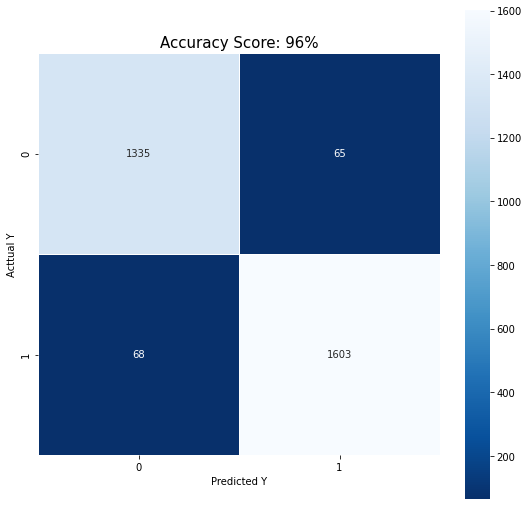

In [55]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Acttual Y');
plt.xlabel('Predicted Y');
title = f'Accuracy Score: {round(accuracy_percentage)}%'
plt.title(title, size = 15);